<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import  imread, imshow
import scipy.ndimage
from PIL import Image

#!pip install --upgrade tensorflow

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor



# Access Dataset via Kaggle API

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [01:21<00:00, 21.8MB/s]
100% 1.62G/1.62G [01:21<00:00, 21.4MB/s]


# Loading the Dataset

In [ ]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


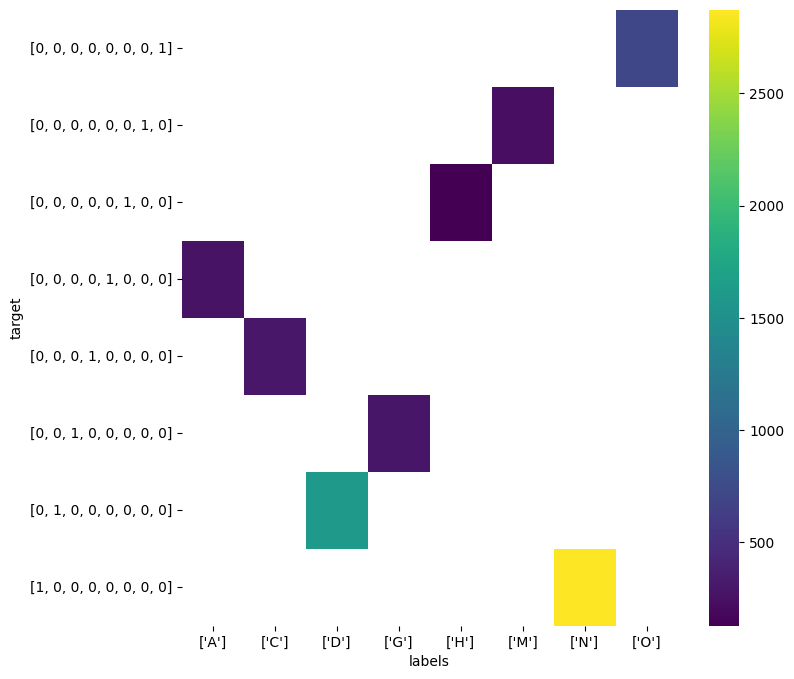

In [ ]:
# @title labels vs target

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['target'].value_counts()
    for x_label, grp in df_data.groupby('labels')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('labels')
_ = plt.ylabel('target')

# Dataset Information

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Loading the Training Data

In [ ]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [ ]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into training and validation sets
train_df, val_df = train_test_split(df_data, test_size=0.2, random_state=123)


# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

def load_and_prepare_dataset(csv_path, images_dir, shuffle=True, batch_size=32):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/Training Images/', shuffle=True, batch_size=32)
val_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/Training Images/', shuffle=False, batch_size=32)


In [ ]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

size of training dataset:  400
size of validation dataset:  400


# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


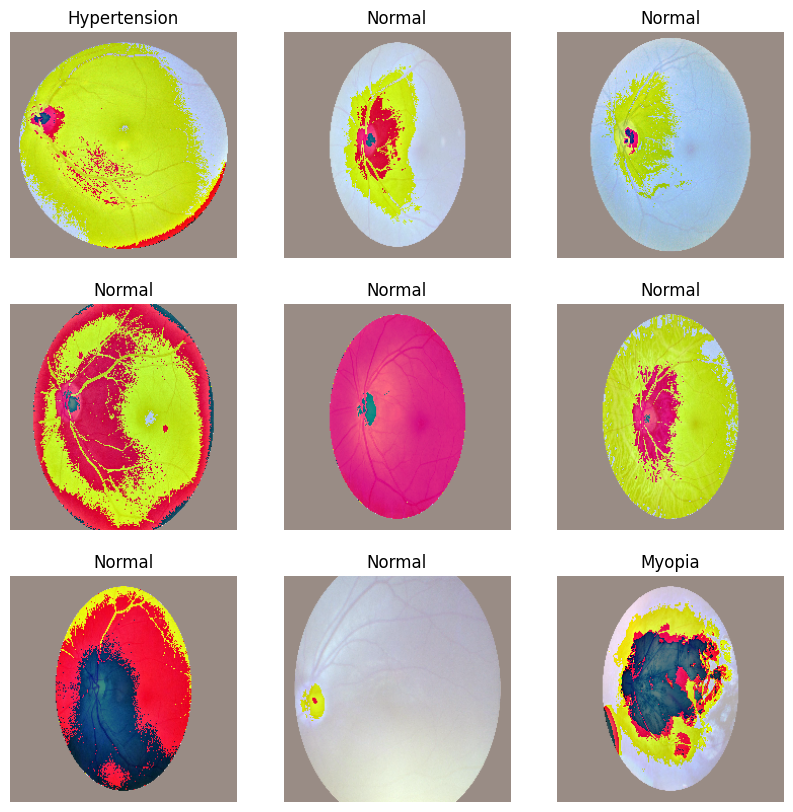

In [ ]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


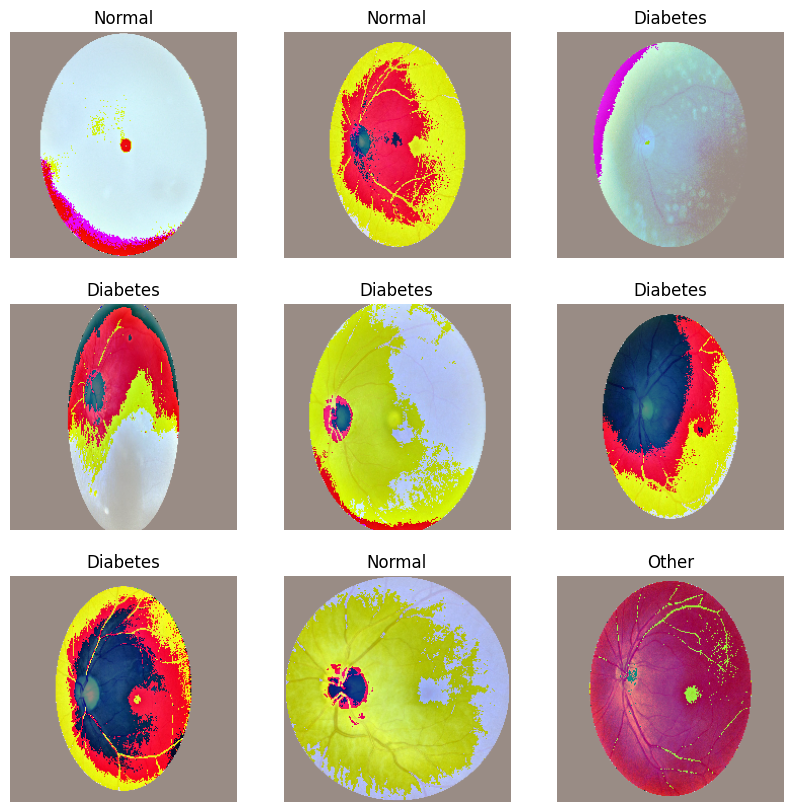

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
400/400 [==============================] - 72s 123ms/step - loss: 1.3256 - accuracy: 0.5152 - val_loss: 1.1885 - val_accuracy: 0.5476
Epoch 2/10
400/400 [==============================] - 63s 119ms/step - loss: 1.1834 - accuracy: 0.5548 - val_loss: 1.1544 - val_accuracy: 0.5611
Epoch 3/10
400/400 [==============================] - 64s 119ms/step - loss: 1.1336 - accuracy: 0.5706 - val_loss: 1.0850 - val_accuracy: 0.5951
Epoch 4/10
400/400 [==============================] - 63s 119ms/step - loss: 1.0930 - accuracy: 0.5849 - val_loss: 1.0429 - val_accuracy: 0.6029
Epoch 5/10
400/400 [==============================] - 62s 116ms/step - loss: 1.0447 - accuracy: 0.6005 - val_loss: 0.9887 - val_accuracy: 0.6155
Epoch 6/10
400/400 [==============================] - 63s 117ms/step - loss: 1.0149 - accuracy: 0.6133 - val_loss: 0.9486 - val_accuracy: 0.6245
Epoch 7/10
400/400 [==============================] - 62s 115ms/step - loss: 0.9785 - accuracy: 0.6273 - val_loss: 0.9355 - val_ac

# Evaluating Model
- Model Accuracy
- Model Loss


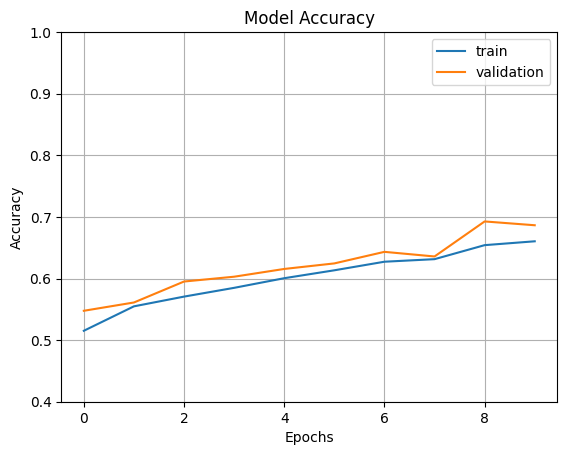

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

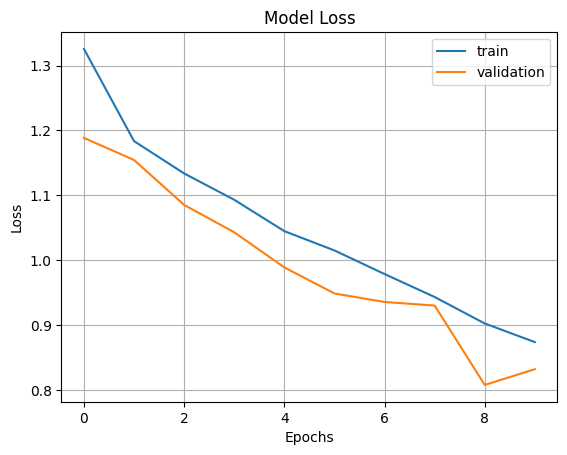

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data

In [ ]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    return image

In [ ]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*]'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')

TypeError: in user code:

    File "<ipython-input-22-8171ae229604>", line 2, in parse_image  *
        image = tf.io.read_file(image_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
print("Size of test dataset: ", len(test_dataset))

Size of test dataset:  0


Making Predictions

In [ ]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

# Prediction Analysis

In [ ]:

# Get the class with the highest probability
pred_class = np.argmax(pred)
print(pred_class)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
class_labels[pred_class]

# Get the top 3 class labels
top3_class_indices = pred[0].argsort()[-3:][::-1]
top3_class_indices

# Get the top 3 class labels
top3_class_labels = [class_labels[i] for i in top3_class_indices]
top3_class_labels

# Get the top 3 class probabilities
top3_class_probabilities = pred[0][top3_class_indices]
top3_class_probabilities

# Visualize the top 3 class labels and their probabilities
plt.bar(top3_class_labels, top3_class_probabilities)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Top 3 Predictions')
plt.show()